In [1]:
#@title Copyright 2021 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Implementation of the Thornthwaite-Mather procedure to map gorundwater recharge
Author: guiattard

Groundwater recharge represents the amount of water comming from precipitation reaching groundwater table. Its determination helps to better understand the available/renewable groundwater in watersheds and so on the shape of groundwater flow systems.

One of the simplest methods to estimate groundwater recharge is the Thornthwaite-Mather procedure (Steenhuis and Van Der Molen, 1986). This procedure was published by Thornthwaite and Mather (1955, 1957). The idea of this procedure is to calculate the water balance in the root zone of the soil where water can be (1) evaporated into the atmosphere under the effect of heat, (2) transpired by vegetation, (3) stored by the soil, and eventually (4) infiltrated when stored water exceeds the field capacity. 

This procedures relies on several parameters and variables described as follow:
- some information about soil texture (e.g. sand and clay content) to describe the hydraulic properties of the soil and its capacity to store/infiltrate,
- some meteorological records: precipation and potential evapotranspiration,

Of course groundwater recharge can be influenced by many other factors such as the slope of the terrain, the snow cover, the variability of the crop/land cover and the irrigation. In the following these aspects are not taken into account.

In the first part of the tutorial, the Earth Engine python API will be initialize, some usefull libraries will be imported, and the location/period of interest will be defined.

In the second part, OpenLandMap datasets related to soil texture will be explored. The wilting point and field capacity of the soil will be calculated by applying some mathematical expressions to multiple images.

In the third part, evapotranspiration and precipitation datasets will be imported. A function will be defined to resample the time resolution of an `ee.ImageCollection` and to homogenize time index of both datasets. Both datasets will then be combined into one.

In the forth and final part, the Thornthwaite-Mather(TM) procedure will be implemented by iterating over the meteorological `ee.ImageCollection`. Finnaly, a comparison between groundwater recharge in two places will be described and the resulting mean annual groundwatr recharge will be displayed over France.

### Run me first
#### Earth Engine API

First of all, run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=XmNmc4YbZMNoExij_9Mtw4_F0i2Ty6vazeT_axFtEYA&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgXfRrd4Mb0mBiQ6tpU7vrgSSDS1v5NIu8IdwYF4R1oMR-pjZu87xQ

Successfully saved authorization token.


#### Other libraries
Import other libraries used in this notebook.

- [**pandas**](https://pandas.pydata.org/): data analysis (including the [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) data structure)
- [**matplotlib**](https://matplotlib.org/): data visualization library,
- [**numpy**](https://numpy.org/): array-processing package,
- [**folium**](https://python-visualization.github.io/folium/): interactive web map


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium

#### Some input parameters
We additionnaly define some parameters used to evaluate the results of our implementation. Particularly:
- The period of interest to get meteorological records ,
- A location of interest based on longitude and latitude coordinates,


In [4]:
# Initial date of interest (inclusive).
i_date = '2015-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Definition of the location of interest with a point
lon = 5.145041
lat = 45.772439 
poi = ee.Geometry.Point(lon, lat)

# A nominal scale in meters of the projection to work in [in meters]
scale = 1000

### From soil texture to hydraulic properties


#### Definitions
Two hydraulic properties of soil are commonly used in the TM procedure:
- the *wilting point* represents the point below what water cannot be extracted by plant roots,
- the *field capacity* represents the point after what water cannot be stored by soil any more. After that point, gravitationnal forces become to high and water starts to infiltrate the lower levels.

Some equations given by Saxton & Rawls (2006) are used to link both parameters to the texture of the soil. The, the calculation of water content at wilting point $θ_{WP}$ can be done as follow:

$$\theta_{WP}= \theta_{1500t} + (0.14 \theta_{1500t} - 0.002)$$ with:

$$\theta_{1500t} = -0.024 S + 0.487 C + 0.006 OM + 0.005(S \times OM) - 0.013 (C \times OM) + 0.068 (S \times C) + 0.031$$

where:
- $S$: represents the sand content of the soil (mass percentage),
- $C$: represents the clay content of the soil (mass percentage),
- $OM$: represents the organic matter content of the soil (mass percentage).

Similarly, the calculation of the water content at field capacity $θ_{FC}$ can be done as follow:

$$\theta_{FC} = \theta_{33t} + (1.283 \theta_{33t}^{2} - 0.374 \theta_{33t}-0.15)$$ with:

$$\theta_{33t} = -0.251 S + 0.195 C + 0.011 OM + 0.006 (S \times OM) - 0.027 (C \times OM) + 0.452 (S \times C) + 0.299$$


#### Determination of soil texture
In the following, OpenLandMap datasets are used to describe, clay, sand and organic carbon content of soil.
A global dataset of soil water content at the field capacity with a resolution of 250 m have been made available by Hengl & Gupta (2019). However, up to know, there si no dataset dedicated to the water content of soil at the wilting point. Consequently, in the following, both parameters will be determined considering the previous equations and using the global datasets giving the sand, clay and organic matter contents of the soil. According to the [description](https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_CLAY-WFRACTION_USDA-3A1A1A_M_v02#description), these OpenLandMap datasets are based on machine learning predictions from global compilation of soil profiles and samples. Processing steps are described in detail [here](https://gitlab.com/openlandmap/global-layers/tree/master/soil). The information (clay, sand content, etc.) is given at 6 standard depths (0, 10, 30, 60, 100 and 200 cm) at 250 m resolution. 

These standard depths and associated bands are defined into list as follow:

In [5]:
# soil depths [in cm] where we have data
olm_depths = [0, 10, 30, 60, 100, 200]
    
# associated bands
olm_bands = ["b" + str(sd) for sd in olm_depths]

We now define a function to get the `ee.Image` associated to the parameter we are intereste in (eg. sand, clay, organic carbon content, etc.)

In [6]:
def get_soil_prop(param):
    """
    This function retun soil properties image 
    param (str): must be one of:
        "S"        - Sand fraction
        "C"        - Clay fraction
        "OC"       - Organic Carbon fraction
    """  
    if param == "S": #Sand fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_WATERCONTENT-33KPA_USDA-4B1C_M/v01"
        # scale factor defined in accordance with dataset description
        scale_factor = 1*0.01
        
    elif param == "C": #Clay fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # scale factor defined in accordance with dataset description
        scale_factor = 1*0.01
        
    elif param == "OC": #Organic Carbon fraction [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # scale factor defined in accordance with dataset description
        scale_factor = 5*0.001 #to get kg/kg
    else:
        return print("error")
    
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset

We apply this function to import soil texture:

In [7]:
# Image associated to the sand content
sand = get_soil_prop("S")

# Image associated to the clay content
clay = get_soil_prop("C")

# Image associated to the organic carbon content
orgc = get_soil_prop("OC")

To illustrate the result, we define a new method for handing Earth Engine tiles and using it to display the caly content of the soil at a given reference depth, to a Leaflet map.

In [8]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

my_map = folium.Map(location=[lat, lon], zoom_start=3)

# Set visualization parameters
vis_params = {
    'bands' : ['b0'],
    'min': 0.01,'max': 1,
    'opacity' : 1,
    'palette': ["white", "#464646"]
}

# Add the sand content data to the map object.
my_map.add_ee_layer(sand, vis_params, 'Sand Content')

# Add a marker at the location of interest
folium.Marker([lat, lon], popup="point of interest").add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

Now, a function is defined to get soil properties at a given location. The following function returns a dictionnary indicating the value of the parameter of interest for each standard depth (in centimetre). In the example below, we are asking for the clay content.

In [9]:
def local_profile(dataset, poi, buffer):
    # we get the values
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()
    profile = prop['features'][0]['properties']
    profile = {key : round(val,3) for key, val in profile.items()}
    
    return profile

profileC = local_profile(clay, poi, scale)
print("Clay content profile at the location of interest: \n", profileC)

Clay content profile at the location of interest: 
 {'b0': 0.22, 'b10': 0.23, 'b100': 0.26, 'b200': 0.25, 'b30': 0.26, 'b60': 0.27}


We now apply the function to plot the profil of the soil regarding sand and clay and organic carbon content at the location of interest:

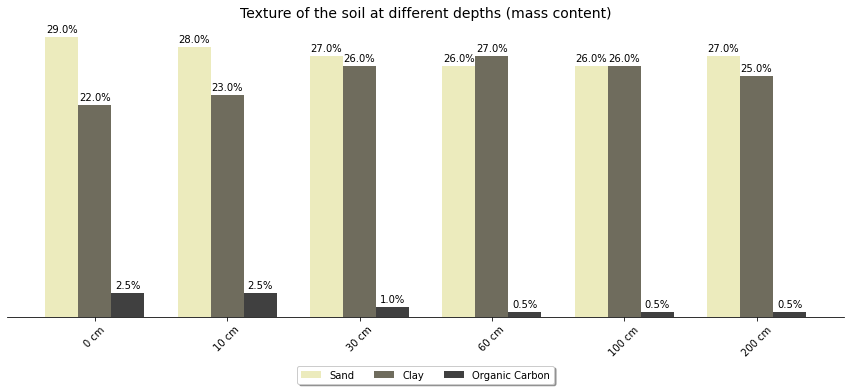

In [10]:
# We get the sand and organic concent profiles:
profileS = local_profile(sand, poi, scale)
profileOC = local_profile(orgc, poi, scale)

# Then we build a bar plot
fig, ax = plt.subplots(figsize=(15,6))
ax.axes.get_yaxis().set_visible(False)

x = np.arange(len(olm_bands))  # the label locations
width = 0.25 # width of bars

rect1 = ax.bar(x-width, [round(100*profileS[b], 2) for b in olm_bands], 
               width, label="Sand", color='#ecebbd')

rect2 = ax.bar(x, [round(100*profileC[b], 2) for b in olm_bands], 
               width, label="Clay", color='#6f6c5d')

rect3 = ax.bar(x+width, [round(100*profileOC[b], 2) for b in olm_bands], 
               width, label="Organic Carbon", color='black', alpha = 0.75)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height) + '%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
autolabel(rect1)
autolabel(rect2)
autolabel(rect3)

ax.set_title('Texture of the soil at different depths (mass content)', fontsize=14)
ax.set_xticks(x)

x_labels = [str(d) + " cm" for d in olm_depths] 
ax.set_xticklabels(x_labels, rotation = 45, fontsize=10)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

plt.show()

#### Mathematical expression to an `ee.Image` for to the calculation of hydraulic properties

Now that we have a description of the soil texture at different depths, we can calulate the water content at the field capacity and at the wilting point according to the equation defined at the begining of this section. Please note that in the equation of Saxton & Rawls (2006), the wilting point and field capacity are calculated using the Organic Matter content ($OM$) and not the Organic Carbon content ($OC$). In the following, we convert $OC$ into $OM$ using the corective factor known as the [Van Bemmelen factor](https://inspire.ec.europa.eu/codelist/SoilDerivedObjectParameterNameValue/organicCarbonContent):

$$0M = 1.724 \times OC$$

Then, we multiply our organic content `ee.Image` by the Van Bemmelen factor:

In [11]:
orgm = orgc.multiply(1.724)

profileOM = local_profile(orgm, poi, scale)
print("Organic Matter content profile at the location of interest: \n", profileOM)

Organic Matter content profile at the location of interest: 
 {'b0': 0.043, 'b10': 0.043, 'b100': 0.009, 'b200': 0.009, 'b30': 0.017, 'b60': 0.009}


We then use the `.expression()` method to calulate wilting point and field capacity images using Saxton & Rawls equations.

In [12]:
# We initialize two constant images for wiliting point and field capacity
WP = ee.Image(0)
FC = ee.Image(0)

# We make the calculation for each bstandard depth so we make a loop
for key in olm_bands:
    # We get the sand, clay and organic matter at the appropriate depth
    si = sand.select(key) #sand
    ci = clay.select(key) #clay
    oi = orgm.select(key) #organic matter
    
    # Then we calculate the wilting point
    # We need the theta_1500t parameter for the given depth
    theta_1500ti = ee.Image(0).expression(
        '-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
        - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031', {
            'S' : si,
            'C' : ci,
            'OM': oi,
        }
    ).rename('T1500ti')
    # then wilting point is calculated at the given depth
    wpi = theta_1500ti.expression(
        'T1500ti + ( 0.14 * T1500ti - 0.002)', {
            'T1500ti' : theta_1500ti
        }
    ).rename('wpi')

    # We add the result as a new band of the global WP
    # We do not forget to cast the type with float()
    WP = WP.addBands(wpi.rename(key).float())
    
    # We fo the same for the field capacity
    # we first need the parameter theta_33t for the given depth:
    theta_33ti = ee.Image(0).expression(
        '-0.251 * S + 0.195 * C + 0.011 * OM +\
        0.006 * (S * OM) - 0.027 * (C * OM)+\
        0.452 * (S * C) + 0.299',{
            'S' : si,
            'C' : ci,
            'OM' : oi,
        }
    ).rename('T33ti')
    
    fci = theta_33ti.expression(
        'T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)',{
            "T33ti" : theta_33ti.select("T33ti")
        }
    )
    
    FC = FC.addBands(fci.rename(key).float())

Let's see the result around our location of interest:

In [13]:
profileWP = local_profile(WP, poi, scale)
print(profileWP)

{'b0': 0.153, 'b10': 0.159, 'b100': 0.176, 'b200': 0.17, 'b30': 0.176, 'b60': 0.182}


We do the same for field capacity:

In [14]:
profileFC = local_profile(FC, poi, scale)
print(profileFC)

{'b0': 0.286, 'b10': 0.292, 'b100': 0.31, 'b200': 0.303, 'b30': 0.308, 'b60': 0.314}


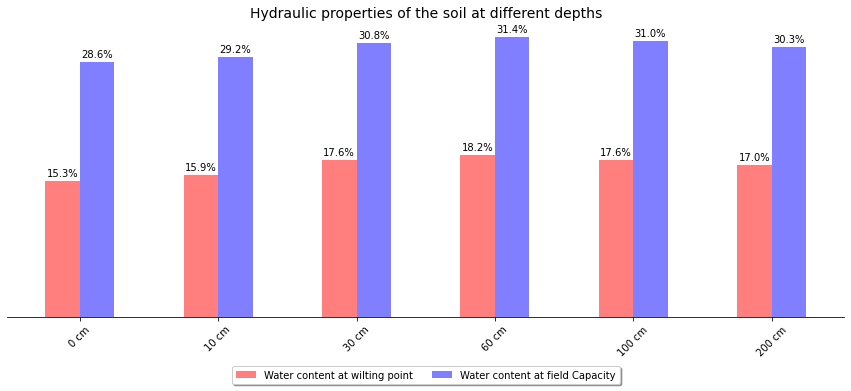

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
ax.axes.get_yaxis().set_visible(False)

x = np.arange(len(olm_bands))  # the label locations
width = 0.25 #width of bars

rect1 = ax.bar(x-width/2, 
               [round(profileWP[b]*100,2) for b in olm_bands], 
               width, 
               label="Water content at wilting point", 
               color='red', alpha = 0.5)

rect2 = ax.bar(x+width/2, 
               [round(profileFC[b]*100, 2) for b in olm_bands], 
               width, label="Water content at field Capacity", 
               color='blue', alpha = 0.5)

autolabel(rect1)
autolabel(rect2)

ax.set_title('Hydraulic properties of the soil at different depths', fontsize=14)
ax.set_xticks(x)

x_labels = [str(d) + " cm" for d in olm_depths] 
ax.set_xticklabels(x_labels, rotation = 45, fontsize=10)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

plt.show()

### Getting meteorological datastets


#### Datasets exploration

The meteorological data used in our implementation of the TM procedure relies on following remote sensing datasets:
- Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) gives precipitations on a daily basis (resolution of 5 km),
- the MODIS Terra Net gives evapotranspiration on a 8-days basis (resolution of 500 m)

Both datasets are imported as follow:

In [17]:
# We select the precipitation band from the precipitaiton datasets
pr = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").select('precipitation').filterDate(i_date, f_date)

# We select the potential evaporation PET band and the quality indicator ET_QC:
pet = ee.ImageCollection("MODIS/006/MOD16A2").select(['PET', 'ET_QC']).filterDate(i_date, f_date)

We now etablish a procedure to get meteorological data around a given location in form of a `pandas.DataFrame`:

In [18]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)
    
    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')
        
    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]
    
    df = df.set_index('datetime')

    return df

Now we can have a closer look around our location of interest:

In [19]:
#local precipitation info
local_pr = pr.getRegion(poi, scale).getInfo()

#transformation into pandas df
pr_df = ee_array_to_df(local_pr, ['precipitation'])
pr_df.head(10)

,time,precipitation
datetime,,
2015-01-01,1420070400000,0.000000
2015-01-02,1420156800000,0.000000
2015-01-03,1420243200000,0.000000
2015-01-04,1420329600000,0.000000
2015-01-05,1420416000000,0.000000
2015-01-06,1420502400000,0.000000
2015-01-07,1420588800000,0.000000
2015-01-08,1420675200000,0.000000
2015-01-09,1420761600000,2.134465


We do the same for potential evaporation:

In [20]:
#local precipitation info
local_pet = pet.getRegion(poi, scale).getInfo()

#transformation into pandas df
pet_df = ee_array_to_df(local_pet, ['PET', 'ET_QC'])
pet_df.head(5)

,time,PET,ET_QC
datetime,,,
2015-01-01,1420070400000,63.0,0
2015-01-09,1420761600000,76.0,0
2015-01-17,1421452800000,44.0,0
2015-01-25,1422144000000,NaN,105
2015-02-02,1422835200000,NaN,8


Looking at both `pandas.DataFrame` shows the following points:
- the time resolution between both datasets is not the same,
- for some reasons, potential evapotranspiration cannot be calulated at some dates. It corresponds to lines where the quality indicator `ET_QC` is higher than 1.

Both issues must be handled before implementing the iterative process: we want to work on a similar timeline with potential evapotranspiration and precipitation, and we want to avoid missing values.

#### Resampling the time resolution of an `ee.ImageCollection`

To tadress these issues (homogenneous time index and missing values), we make a sum resampling of both datasets by month. When `PET` cannot be calculated, the monthly averaged value is considered. The resampling procedure reads as follow:

In [21]:
def sum_resampler(coll, freq, unit, scale_factor, band_name):
    """
    This function aims to resample the time scale of an ee.ImageCollection.
    The function returns an ee.ImageCollection with the averaged sum of the 
    band on the selected frequence.

    coll: (ee.ImageCollection) only one band can be handled
    freq: (int) corresponds to the resampling frequence
    unit: (str) corresponds to the resampling time unit.
                must be 'day', 'month' or 'year'
    scale_factor (float): scaling factor used to get our value in the unit we want
    band_name (str) name of the output band
    """

    #We determine the initial and final dates of our collection
    firstdate = ee.Date(coll.sort('system:time_start', True).first().get('system:time_start'))
    lastdate = ee.Date(coll.sort('system:time_start', False).first().get('system:time_start'))
    
    # We determine the time difference between both
    diff_dates = lastdate.difference(firstdate, str(unit) + "s")

    # We define a new time index (for output)
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)
    
    # we define the function that will be applied to our new time idenx sequence
    def apply_resampling(date_index):
        startdate = firstdate.advance(ee.Number(date_index), unit)
        enddate = firstdate.advance(ee.Number(date_index).add(freq), unit)

        diff_days = enddate.difference(startdate, 'days')
        image = coll.filterDate(startdate, enddate).mean().multiply(diff_days).multiply(scale_factor).rename(band_name)

        return image.set('system:time_start', startdate.millis())

    # We map the function to our new time index
    res = new_index.map(apply_resampling)
    
    # We transform the result into an ee.ImageCollection
    res = ee.ImageCollection(res)
    return res

The precipitation dataset can now easily be resampled by month as follow: 

In [22]:
pr_m = sum_resampler(pr, 1, 'month', 1, 'PR')
pr_m.getRegion(poi, scale).getInfo()[:5]

[['id', 'longitude', 'latitude', 'time', 'PR'],
 ['0', 5.142855001584261, 45.77365530231022, 1420070400000, 83.12794733047485],
 ['1',
  5.142855001584261,
  45.77365530231022,
  1422748800000,
  61.235233306884766],
 ['2',
  5.142855001584261,
  45.77365530231022,
  1425168000000,
  60.416391015052795],
 ['3',
  5.142855001584261,
  45.77365530231022,
  1427846400000,
  48.404173851013184]]

For evapotranspiration, we have to be carefull with the unit. The dataset gives us a 8-days sum and a scale factor of 10 is applied. Then, to get an homogeneous unit, we need to rescale by dividing by 8 and 10: $\frac{1}{10 \times 8} = 0.0125$.

In [23]:
pet_m = sum_resampler(pet.select('PET'), 1, 'month', 0.0125, 'PET')
pet_m.getRegion(poi, scale).getInfo()[:5]

[['id', 'longitude', 'latitude', 'time', 'PET'],
 ['0',
  5.142855001584261,
  45.77365530231022,
  1420070400000,
  23.637500000000003],
 ['1', 5.142855001584261, 45.77365530231022, 1422748800000, 39.2],
 ['2', 5.142855001584261, 45.77365530231022, 1425168000000, 76.434375],
 ['3', 5.142855001584261, 45.77365530231022, 1427846400000, 137]]

We can now combine both `ee.Imagecollection` using the `ee.ImageCollection.combine` method. In our case, we choose to combine `pet_m` to `pr_m`. Consequently `pet_m` images will be stacked in the `pr_m` collection without respect of the the time index. Consequently, make sure that both `ee.ImageCollection` have the same time index berfore combing.

In [24]:
# We combine precipitation and evapotranspiration
meteo = pr_m.combine(pet_m)
meteo.getRegion(poi, scale).getInfo()[:5]

[['id', 'longitude', 'latitude', 'time', 'PR', 'PET'],
 ['0',
  5.142855001584261,
  45.77365530231022,
  1420070400000,
  83.12794733047485,
  23.637500000000003],
 ['1',
  5.142855001584261,
  45.77365530231022,
  1422748800000,
  61.235233306884766,
  39.2],
 ['10',
  5.142855001584261,
  45.77365530231022,
  1446336000000,
  35.43960928916931,
  39.5],
 ['11',
  5.142855001584261,
  45.77365530231022,
  1448928000000,
  16.603714764118195,
  25.058333333333337]]

We evaluate the result on our location of interest as follow: 

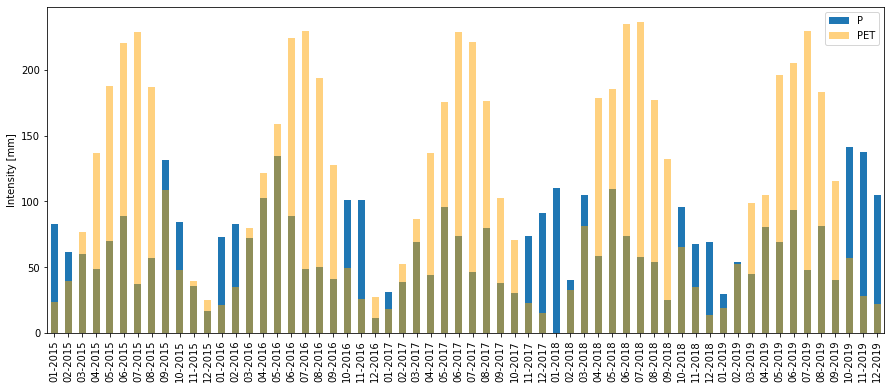

In [25]:
meteo_arr = meteo.getRegion(poi, scale).getInfo()
meteo_df = ee_array_to_df(meteo_arr , ['PR', 'PET']).sort_index()

# We plot the result
fig, ax = plt.subplots(figsize = (15,6))
meteo_df['PR'].plot(kind = 'bar', ax = ax, label = "P")
meteo_df['PET'].plot(kind = 'bar', ax = ax, label = "PET", color = 'orange', alpha = 0.5)

ax.legend()
ax.set_ylabel('Intensity [mm]')
ax.set_xlabel(None)

x_labels = meteo_df.index.strftime('%m-%Y') 
ax.set_xticklabels(x_labels, rotation = 90, fontsize=10)

plt.show()

### Implementation of the TM procedure
 


#### Description
Some additionnal definitions are requested to formalize the Thornthwaite-Mather procedure. The following definitions are given in accordance with Allen et al. (1998) (the document can be downloaded [here](http://www.climasouth.eu/sites/default/files/FAO%2056.pdf)):

$$TAW = 1000 \times (\theta_{FC} − \theta_{WP})\times Z{r}$$ where:
- $TAW$: the total available soil water in the root zone [$mm$],
- $\theta_{FC}$: the water content at the field capacity [$m^{3} m^{-3}$],
- $\theta_{WP}$: the water content at wilting point [$m^{3} m^{-3}$],
- $Z_{r}$: the rooting depth [$mm$],

Typical values of $\theta_{FC}$ and $\theta_{WP}$ for different soil types are given in the Table 19 of Allen et al. (1998).

The readily available water ($RAW$) is given by $RAW = p \times TAW$, where $p$ is the average fraction of $TAW$ that can be depleted from the root zone before moisture stress (ranging between 0 to 1). Ranges of maximum effective rooting depth $Z_{r}$, and soil water depletion fraction for no stress $p$, for common crops are given in the Table 22 of Allen et al. (1998). This quantity is also noted $ST_{FC}$ which is the available water stored at field capacity in the root zone. In this tutorial, both parameters are assumed to be constant and respectively equal to $Z_{r} = 1$ and $p = 0.5$.

In [26]:
#initialization :
Zr = ee.Image(1.)
p = ee.Image(0.5)

In the following, we also consider an averaged value between reference depth of the water content at wilting point and filed capacity:

In [27]:
# We define a function to get an average value of
# FC and WP
def olm_prop_mean(olm_image, band_output_name):
  mean_image = olm_image.expression(
      "(b0 + b10 + b30 + b60 + b100 + b200) / 6", {
          "b0" : olm_image.select("b0"),
          "b10" : olm_image.select("b10"),
          "b30" : olm_image.select("b30"),
          "b60" : olm_image.select("b60"),
          "b100" : olm_image.select("b100"),
          "b200" : olm_image.select("b200")

      }
  ).rename(band_output_name)
  return mean_image

FCm = olm_prop_mean(FC, 'fc_mean')
WPm = olm_prop_mean(WP, 'wp_mean')

# The theoretical available water :
TAW = (FCm.select("fc_mean").subtract(WPm.select("wp_mean"))).multiply(1000).multiply(Zr)
#TAW = (FC.select("b0").subtract(WP.select("b0"))).multiply(1000).multiply(Zr)

# Stored water at the field capacity:
STfc = TAW.multiply(p)

The Thornthwaite-Mather procedure used to estimate groundwater recharge is explicitely described by Steenhuis and Van der Molen (1985). This procedures uses monthly sums of potential evaporation and cumulative precipitation, and the moisture status of the soil which is calculated iteratively. The moisture status of the soils depends on the accumulated potential water loss ($APWL$). This parameter is calculated depending on whether the potential evaporation is greater than or less than the cumulative precipitation. The procedure reads as follow:

**When potential evapotranspiration is higher that precipitation**:

In that case, $PET>P$ and $APWL_{m}$ is incremented as follow:
$APWL_{m} = APWL_{m - 1} + (PET_{m} - P_{m})$ where:
- $APWL_{m}$ (respectively $APWL_{m - 1}$) represents the accumulated potential water loss for the month $m$ (respectively at the previous month $m - 1$)
- $PET_{m}$ the cumulative optential evapotranspiration at month $m$,
- $P_{m}$ the cumulative precipitation at month $m$,

and the relationship between $APWL$ and the amount of water stored in the root zone for the month $m$ is expressed as:
$ST_{m} = ST_{FC} \times [\textrm{exp}(-APWL_{m}/ST_{FC})]$ where $ST_{m}$ is the available water stored in the root zone for the month $m$.

**When potential evapotranspiration is lower that precipitation**:

In that case, $PET<P$ and $ST_{m}$ is incremented as follow:
$ST_{m} = ST_{m-1} + (P_{m} - PET_{m})$

If the storage $ST_{m}$ is higher than the water stored at the field capacity ($ST_{m} > ST_{FC}$) the recharge is calculated as:
$R_{m} = ST_{m} - ST_{FC} + P_{m} - PET_{m}$

In addtion, the water stored at the end of the month $m$ becomes equal to $ST_{FC}$ and $APWL_{m}$ is set equal to zero.

If the storage $ST_{m}$ is lower than $ST_{FC}$, $APWL_{m}$ is implemented as follow:
$APWL_{m} = ST_{FC} \times \textrm{ln}(ST_{m}/ST_{FC})$, and no percolation occur.

**Initialization**:

To initialize the calculation $APWL_{0}$ is set equal to 0, and $ST_{0}$ is set equal to $ST_{FC}$.

#### Iteration over an `ee.ImageCollection`
The procedure is implented by means of the `ee.ImageCollection.iterate()` method.

We first define an initial image used to start the iterative process as follow:

In [28]:
# we define our time0 according to the start of our meteo collection
time0 = meteo.first().get('system:time_start')

# We now initialize the different bands :
# We do not forget to cast the type of the data with a .float()
initial_rech = ee.Image(0).set('system:time_start', time0).select([0], ['RECH']).float()
initial_apwl = ee.Image(0).set('system:time_start', time0).select([0], ['APWL']).float()
initial_st   = STfc.set('system:time_start', time0).select([0], ['ST']).float()
initial_pr = ee.Image(0).set('system:time_start', time0).select([0], ['PR']).float()
initial_pet = ee.Image(0).set('system:time_start', time0).select([0], ['PET']).float()

We combine all these images into one adding new bands to the first using the `ee.Image.addBands` method:


In [29]:
initial_image  = initial_rech.addBands(initial_apwl)
initial_image  = initial_image.addBands(initial_st)
initial_image  = initial_image.addBands(initial_pr)
initial_image  = initial_image.addBands(initial_pet)

We also initialize a list in which new images will be added after each iteration:

In [30]:
my_list = ee.List([initial_image]) 

The iterative procedure is now implemented into a function:

In [31]:
def recharge_calculator(image, my_list):
    """
    this function contains the iterative process
    """
    # We load the previous image stored in the list
    prev_im = ee.Image(ee.List(my_list).get(-1))
    
    # We get the gate of the current ee.Image of the collection 
    localdate = ee.Date(image.get('system:time_start'))
        
    # We store the previous APWL and ST as images
    prev_apwl = prev_im.select('APWL')
    prev_st = prev_im.select('ST')
    
    # We store the current precipitation and evapotranspiration:
    P = image.select('PR')
    PET = image.select('PET')
    
    # We initialize the new values of recharge, apwl and st:
    # DO NOT FORGET TO CAST THE TYPE WITH .float()
    new_rech = ee.Image(0).set('system:time_start', localdate.millis()).select([0], ['RECH']).float()
    new_apwl = PET.subtract(PET).set('system:time_start', localdate.millis()).select([0], ['APWL']).float()
    new_st = prev_st.set('system:time_start', localdate.millis()).select([0], ['ST']).float()
    
    # We now calculate parameters depending on the situation:
    # We Create binary layers using logical operations.
    #zone1 is the area where PET > P
    zone1 = PET.gt(P)

    zone1_apwl = prev_apwl.add(PET.subtract(P)).rename("APWL")
    new_apwl = new_apwl.where(zone1, zone1_apwl)
    
    zone1_st = prev_st.multiply(ee.Image.exp(zone1_apwl.divide(STfc).multiply(-1))).rename("ST")
    new_st = new_st.where(zone1, zone1_st)
    
    #zone2 is the area where PET <= P
    zone2 = PET.lte(P)
    
    zone2_st = prev_st.add(P).subtract(PET).rename("ST")
    new_st = new_st.where(zone2, zone2_st)
    
    #zone21 is the area where PET <= P and ST >= STfc
    zone21 = zone2.And(zone2_st.gte(STfc))
    
    zone21_re = zone2_st.subtract(STfc).rename("RECH")
    new_rech = new_rech.where(zone21, zone21_re)
    new_st = new_st.where(zone21, STfc)
    
    #zone 22 is the area where PET <= P and ST < STfc
    zone22 = zone2.And(zone2_st.lt(STfc))
    
    zone22_apwl = STfc.multiply(-1).multiply(ee.Image.log(zone2_st.divide(STfc))).rename("APWL")
    new_apwl = new_apwl.where(zone22, zone22_apwl)
    
    # A mask is created to not calculate a recharge in area where 
    # we cannot have PET, P, FCm, WPm (urban areas, etc...)
    mask = PET.gte(0).And(P.gte(0)).And(FCm.gte(0)).And(WPm.gte(0))

    # We aply the mask
    new_rech = new_rech.updateMask(mask)

    # Now we add all Bands to our ee.Image
    new_image = new_rech.addBands(new_apwl)
    new_image = new_image.addBands(new_st)
    new_image = new_image.addBands(P)
    new_image = new_image.addBands(PET)
    
    return ee.List(my_list).add(new_image)

The TM procedure can now be applied to the meteorological `ee.ImageCollection`:

In [32]:
# We run the procedure to get the result in a list
rech_list = meteo.iterate(recharge_calculator, my_list)

# We remove the initial image from our list
rech_list = ee.List(rech_list).remove(initial_image)

# We tranform our list into an ImageCollection
rech_coll = ee.ImageCollection(rech_list)

Let's have a look at the result around the location of interest:

In [33]:
arr = rech_coll.getRegion(poi, scale).getInfo()
rdf = ee_array_to_df(arr, ['PR', 'PET', 'APWL', 'ST', 'RECH']).sort_index()
rdf.head(12)

,time,PR,PET,APWL,ST,RECH
datetime,,,,,,
2015-01-01,1420070400000,83.127947,23.637500,0.000000,6.650681e+01,59.490450
2015-02-01,1422748800000,61.235233,39.200000,0.000000,6.650681e+01,22.035233
2015-03-01,1425168000000,60.416391,76.434375,527.000626,7.478765e-10,0.000000
2015-04-01,1427846400000,48.404174,137.000000,448.935907,1.154736e-06,0.000000
2015-05-01,1430438400000,70.076297,187.550000,237.667646,3.061985e-01,0.000000
2015-06-01,1433116800000,89.217610,220.500000,131.282390,9.238091e+00,0.000000
2015-07-01,1435708800000,36.950253,228.915625,191.965372,3.709521e+00,0.000000
2015-08-01,1438387200000,56.904872,186.871875,321.932375,2.931400e-02,0.000000
2015-09-01,1441065600000,131.345901,108.656250,71.435251,2.271897e+01,0.000000


The result can be displayed in form of a barplot as follow:

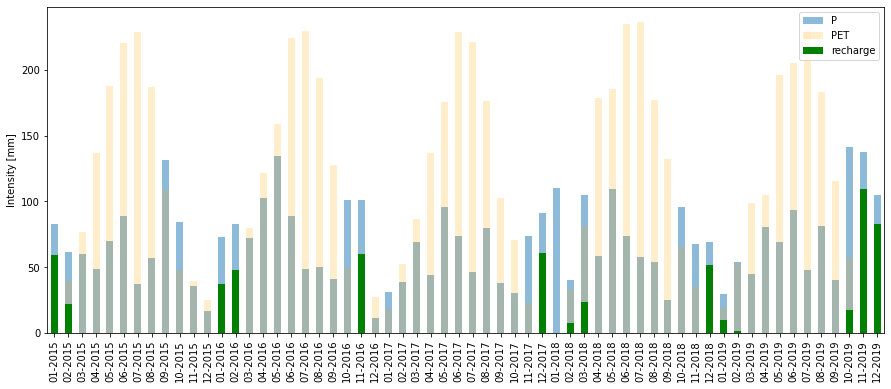

In [34]:
# We plot the result
fig, ax = plt.subplots(figsize = (15,6))

rdf['PR'].plot(kind = 'bar', ax = ax, label = "P", alpha = 0.5)
rdf['PET'].plot(kind = 'bar', ax = ax, label = "PET", color = 'orange', alpha = 0.2)
rdf['RECH'].plot(kind = 'bar', ax = ax, label = "recharge", color = 'green', alpha = 1)


ax.legend()
ax.set_ylabel('Intensity [mm]')
ax.set_xlabel(None)

x_labels = rdf.index.strftime('%m-%Y') 
ax.set_xticklabels(x_labels, rotation = 90, fontsize=10)
# Rotate tick marks on x-axis

plt.show()

We also are interested in the annual average recharge over the period of interest. To do that, we can resample the `DataFrame` we've just created:

In [35]:
rdfy = rdf.resample('Y').sum()
rdfy_mean = rdfy['RECH'].mean()
mean_recharge = int(rdfy_mean)
print("The mean annual recharge at our point of interest is", mean_recharge, "mm/an")

The mean annual recharge at our point of interest is 118 mm/an


#### Groundwater recharge mapping and comparison between multiple places

We now may want to get local information about groundwater recharge and/or map this variable on an area of interest.

Let's define a function to get the local information based on the `ee.ImageCollection` we've just built:

In [36]:
def get_local_recharge(i_date, f_date, lon, lat, scale): 
    """
    This function returns an pandas df describing the cumulative groundwater recharge by month
    """
    # Definition of the location of interest with a point
    poi = ee.Geometry.Point(lon, lat)
    rarr = rech_coll.filterDate(i_date, f_date).getRegion(poi, scale).getInfo()
    rdf = ee_array_to_df(rarr, ['PR', 'PET', 'APWL', 'ST', 'RECH']).sort_index()
    return rdf

We now use this function on a second point of interest located in the south of France:

In [37]:
lon2 = 4.137152
lat2 = 43.626945

rdf2 = get_local_recharge(i_date, f_date, lon2, lat2, scale)
rdf2y = rdf2.resample('Y').sum()
rdf2y.head()

,PR,PET,APWL,ST,RECH
datetime,,,,,
2015-12-31,602.685190,1479.557292,3483.903074,225.958865,22.609315
2016-12-31,668.897704,1449.505208,3632.165578,268.858086,52.551937
2017-12-31,371.787006,1538.359375,7834.083159,122.263898,16.356241
2018-12-31,826.732359,1458.902083,3520.025304,369.730718,80.481089
2019-12-31,550.755352,1454.181250,5354.379859,263.273997,88.010949


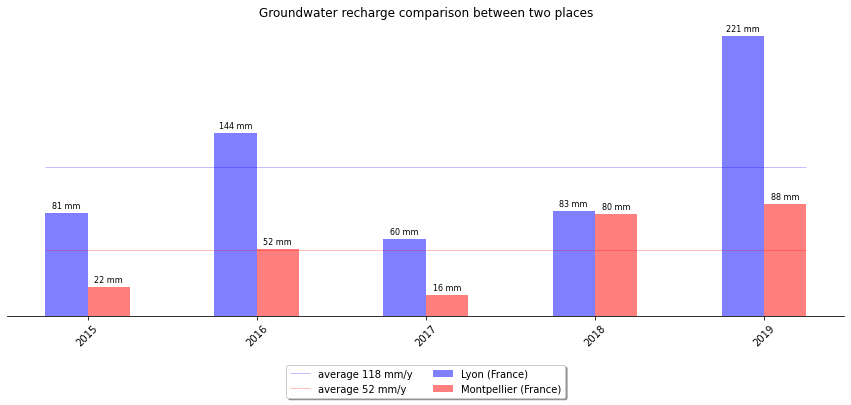

In [38]:
fig, ax = plt.subplots(figsize=(15,6))
ax.axes.get_yaxis().set_visible(False)

x = np.arange(len(rdfy))  # the label locations
width = 0.25 #width of bars

rect1 = ax.bar(x-width/2, rdfy.RECH, width, label = "Lyon (France)", color='blue', alpha = 0.5)
rect2 = ax.bar(x+width/2, rdf2y.RECH, width, label = "Montpellier (France)", color='red', alpha = 0.5)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)) + ' mm',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
autolabel(rect1)
autolabel(rect2)

place1mean = int(rdfy['RECH'].mean())
ax.hlines(place1mean, xmin = min(x)-width, xmax = max(x)+width, 
          color = 'blue', lw = 0.5,
          label = 'average ' + str(place1mean) + " mm/y", alpha = 0.5)

place2mean = int(rdf2y['RECH'].mean())
ax.hlines(place2mean, xmin = min(x)-width, xmax = max(x)+width, 
          color = 'red', lw = 0.5,
          label = 'average ' + str(place2mean) + " mm/y", alpha = 0.5)

ax.set_title('Groundwater recharge comparison between two places', fontsize=12)
ax.set_xticks(x)

x_labels = rdfy.index.year.tolist()
ax.set_xticklabels(x_labels, rotation = 45, fontsize=10)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

plt.show()

To get a map of groundwater recharge, let's calculate the mean annual value:

In [39]:
# We calculate the annual recharge average
annual_rech = rech_coll.select("RECH").mean().multiply(12)

# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset France.
france = countries.filter(ee.Filter.eq('ADM0_NAME', 'France'))

# We clip the ee.Image around the region of interest
rech_france = annual_rech.clip(france)

And finnaly the map can be drawn.

In [40]:
my_map = folium.Map(location=[lat, lon], zoom_start=6)

# Set visualization parameters for recharge.
vis_params = {
    'bands' : 'RECH',
    'min': 0,'max': 400,
    'opacity' : 1,
    'palette': ['ff5d0f', 'f3ff40', '42fff6', '1303ff']
}

# Add the recharge ee.Image to the map object.
my_map.add_ee_layer(rech_france, vis_params, 'Recharge')

# Add a marker at the location of interest
folium.Marker([lat, lon], popup="point of interest 1").add_to(my_map)
folium.Marker([lat2, lon2], popup="point of interest 2").add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

### Bibliography

**Allen RG, Pereira LS, Raes D, Smith M (1998).** Crop evapotranspiration: guidelines for computing crop water requirements. *Irrigation and Drainage Paper 56*, FAO, Rome

**Saxton, K. E., & Rawls, W. J. (2006).** Soil water characteristic estimates by texture and organic matter for hydrologic solutions. *Soil science society of America Journal*, 70(5), 1569-1578.

**Steenhuis, T. S., & Van der Molen, W. H. (1986).** The Thornthwaite-Mather procedure as a simple engineering method to predict recharge. *Journal of Hydrology*, 84(3-4), 221-229.

**Thornthwaite, C. W., & Mather, J. R. (1957).** Instructions and tables for computing potential evapotranspiration and the water balance. *Publ. Climatol.*, 10(3).



### Aknowledgements

Thanks to Susanne Benz for precious advises.